In [1]:
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd, time, matplotlib.pyplot as plt, math, ast, re
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import statsmodels.api as sm, numpy as np
from geopy.distance import great_circle
from shapely.geometry import Polygon
import ast
%matplotlib inline
ox.config(use_cache=True, log_file=True, log_console=True, log_filename='analyze_stats_neighborhoods',
          data_folder='G:/Geoff/osmnx/neighborhoods', cache_folder='G:/Geoff/osmnx/cache/neighborhoods')

In [2]:
df = pd.read_csv('stats_every_nhood.csv', encoding='utf-8')
len(df)

6824

In [3]:
df_plot = df.dropna(subset=['n'])

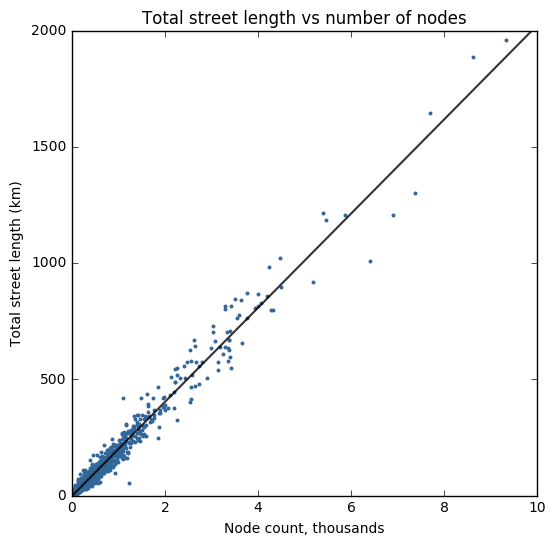

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
x = df_plot['n'] / 1000
y = df_plot['street_length_total'] / 1000

xlim = [0, math.ceil(x.max()/10)*10] #round to nearest greater 100
ylim = [0, math.ceil(y.max()/200)*200] #round to nearest greater 20

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.8, linewidth=1.5, zorder=1)
ax.scatter(x=x, y=y, c='#336699', linewidths=0, alpha=1, s=8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_xlim((0,15000))
#ax.set_ylim((0,3000))

ax.set_title('Total street length vs number of nodes')
ax.set_xlabel('Node count, thousands')
ax.set_ylabel('Total street length (km)')

fig.savefig(filename='images/usa-ua-street-length-vs-nodes', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
print('r-squared:', round(results.rsquared, 2))
results.params

r-squared: 0.98


const     -2.006278
n        202.362661
dtype: float64

In [6]:
# unpack k-counts and k-proportion dicts into individiual keys:values
def unpack(row):
    stats = row.to_dict()
    try:
        for k, count in ast.literal_eval(stats['streets_per_node_counts']).items():
            stats['int_{}_streets_count'.format(k)] = count
        for k, proportion in ast.literal_eval(stats['streets_per_node_proportion']).items():
            stats['int_{}_streets_prop'.format(k)] = proportion
    except Exception as e:
        print(e)
        pass
        
    return pd.Series(stats)

In [7]:
df = df.apply(unpack, axis=1)

malformed node or string: nan
malformed node or string: nan
malformed node or string: nan
malformed node or string: nan
malformed node or string: nan
malformed node or string: nan
malformed node or string: nan


In [8]:
df.columns

Index(['area', 'area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg', 'city',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid', 'int_0_streets_count',
       'int_0_streets_prop', 'int_10_streets_count', 'int_10_streets_prop',
       'int_1_streets_count', 'int_1_streets_prop', 'int_2_streets_count',
       'int_2_streets_prop', 'int_3_streets_count', 'int_3_streets_prop',
       'int_4_streets_count', 'int_4_streets_prop', 'int_5_streets_count',
       'int_5_streets_prop', 'int_6_streets_count', 'int_6_streets_prop',
       'int_7_streets_count', 'int_7_streets_prop', 'int_8_streets_count',
       'int_8_streets_prop', 'int_9_streets_count', 'int_9_streets_prop',
       'intersection_density_km', 'k_avg', 'm', 'n', 'nhood',
       'node_density_km', 'pagerank_max', 'pagerank_max_node', 'pa

In [9]:
cols = ['area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop', 'intersection_density_km',
       'k_avg', 'm', 'n', 'city', 'node_density_km', 'pagerank_max',
       'pagerank_min',
       'self_loop_proportion', 'street_density_km', 'street_length_avg',
       'street_length_total', 'street_segments_count', 'streets_per_node_avg', 'city']
summary = df[cols]
summary = summary.describe().T.drop(['count', '25%', '75%'], axis=1).applymap(lambda x: round(x, 3))
summary.to_csv('data/summary.csv', encoding='utf-8')

In [10]:
variable = 'intersection_density_km'
df[['nhood', 'city', variable]].sort_values(by=variable)

,nhood,city,intersection_density_km
4143,Rio Grande,Albuquerque,0.000000
185,Portage Valley,Anchorage,0.049917
196,Turnagain Arm,Anchorage,0.095884
172,Eklutna Valley,Anchorage,0.161442
634,Verdugo Mountains,Glendale,0.209951
5224,Bells Bend,Nashville,0.327985
630,Scholl Canyon,Glendale,0.335694
1730,Brown Island,Jacksonville,0.336730
2075,Vista Park,Orlando,0.454637
1224,Tijuana River Valley,San-Diego,0.470063


In [12]:
df['area'].describe()

count    6.817000e+03
mean     5.322109e+06
std      1.546329e+07
min      7.591496e+03
25%      6.991377e+05
50%      1.738208e+06
75%      4.129403e+06
max      3.233061e+08
Name: area, dtype: float64

In [16]:
# only look at large neighborhoods
min_area = 1738208
variable = 'streets_per_node_avg'
df[df['area'] > min_area][['nhood', 'city', variable]].sort_values(by=variable)

,nhood,city,streets_per_node_avg
630,Scholl Canyon,Glendale,1.400000
5841,Sonoma Ranch,San-Antonio,1.500000
5673,Elm Creek,San-Antonio,1.666667
1890,University Club,Jacksonville,1.740741
634,Verdugo Mountains,Glendale,1.750000
1730,Brown Island,Jacksonville,1.888889
175,Glen Alps,Anchorage,1.916667
605,Brockmont,Glendale,1.960000
670,Shady Canyon,Irvine,1.962963
2512,Cherry Hill,Fort-Wayne,2.025000
